# Graph Theory

The purpose of this notebook is to understand graph theoretical concepts and implement some graph theoretical algorithms. You will use the `networkx` package (see intro to networkx notebooks) for visualisation purposes but generally we will require you to implement the different graph theoretical algorithms without networkx.



In [1]:
# imports
import networkx as nx
import numpy as np
from sklearn.datasets import make_classification, fetch_california_housing
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.spatial.distance import cdist
from scipy.sparse import linalg

## 1. Graph construction from data points

Following from our lectures, we will construct a graph from data points.

We will first use the  [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function to construct some data with two classes.

In [2]:
# construct some point clouds with two clusters
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=2, random_state=1)

We will now compute a distance matrix using the Euclidean distance between each data point. You have already done this before, so we won't require you to do it again.

In [3]:
# defining an empty adjacency matrix
distance_matrix = np.zeros([X.shape[0],X.shape[0]])

# manually looping over each pair of points
for i in range(X.shape[0]):
  for j in range(X.shape[0]):
    # compute euclidean distance between points 
    distance_matrix[i,j] = np.sqrt(np.sum((X[i,:]-X[j,:])**2))

Lets visualise our distance matrix.

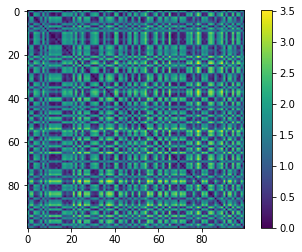

In [4]:
# plot a heatmap of the distance matrix
plt.imshow(distance_matrix)
plt.colorbar();


Using other functions we can also compute the distance between points. Here we use the scipy  [`cdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)function to yield the same results.

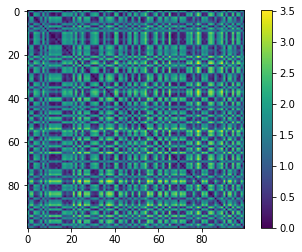

In [5]:
# computing distance matrix using cdist
distance_matrix = cdist(X, X, 'euclidean')

# plot a heatmap of the distance matrix
plt.imshow(distance_matrix);
plt.colorbar()

We are interested in defining edge weights to be larger when the nodes are closer. Here we want to compute our adjacency matrix using a similarity function $s$ on the distance values as:

$$
A_{ij} = s(d_{ij}) = e^{-d_{ij}} \, ,
$$

where $d$ is our distance between points $i$ and $j$.

Please then set the diagonal to zero.

In [6]:
## EDIT THIS CODE

# compute the exponential of each negative matrix element
A = np.exp(-distance_matrix) ## <-- SOLUTION

# fill the diagonal with zeros
np.fill_diagonal(A,0) ## <-- SOLUTION

Lets now filter out the weaker edges. Remove edges with similarity smaller than 0.3.



In [7]:
## EDIT THIS CODE

# set all edges below weight=0.3 to zero
A[A<0.3] = 0 ## <-- SOLUTION

Now lets visualise our graph using `networkx`.

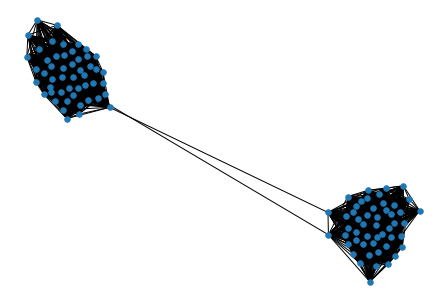

In [8]:
# constructing a networkx graph object
g = nx.Graph(A)

# drawing networkx graph
nx.draw(g,node_size=30)

## 2. Construct Laplacian

We now want to define the combinatorial Laplacian of our graph as,

$$
\boldsymbol L = \boldsymbol D - \boldsymbol A
$$ 

where $\boldsymbol D$ is our diagonal matrix of node degrees and $\boldsymbol A$ is our adjacency matrix which we defined earlier.

To define our diagonal matrix of degrees $\boldsymbol D$, we must:

1.  Sum over the rows of our adjacency matrix
2.  Set to a diagonal matrix

Its important to note that we have weighted edges and therefore the degree is simply the sum over the weighted edges.


In [9]:
## EDIT THIS CODE

# define diagonal matrix of node degrees
weighted_degree = A.sum(axis=1) 

# create diagonal matrix of degree
D = np.diag(weighted_degree) ## <-- SOLUTION

In [10]:
## EDIT THIS CODE

# define Laplacian
L = D-A  ## <-- SOLUTION

We can also construct the symmetric normalized Laplacian,

$$
\boldsymbol L = \boldsymbol I - \boldsymbol D^{-1/2}\boldsymbol A \boldsymbol D^{-1/2}
$$ 





In [11]:
## EDIT THIS CODE

# computing inverse square root vector of degree
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)

# define the normalised Laplacian
L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt)) ## <-- SOLUTION

## 3. Spectral Partition

Lets now examine the spectrum of our Laplacian. We will use the scipy [eigsh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html) function here to compute the eigenvectors and eigenvalues of our Laplacian.

Note that the eigenvalues and eigenvectors are ordered from smallest to largest.



In [12]:
# return the smallest magnitude eigenvectors and eigenvalues
eigenvals, eigenvecs = linalg.eigsh(L_norm, 2, which="SM", return_eigenvectors=True)


The first eigenvalue should be zero, however, we will see here that its not quite zero due to precision errors in the calculation.


In [13]:
## EDIT THIS CODE


# printing the eigenvalues
print('The first eigenalue is: {}'.format(eigenvals[0])) ## <-- SOLUTION
print('The second eigenalue is: {}'.format(eigenvals[1])) ## <-- SOLUTION

The first eigenalue is: -2.1225968031834963e-16
The second eigenalue is: 0.0008143962312500223


We are now interested in a spectral partition. Remember that the second eigenvalue (known as algebraic connectivity or the spectral gap) corresponds to an eigenvector where the nodes are split into two groups defined by their sign (positive or negative). The resulting eigenvector is also known as the Fiedler vector.


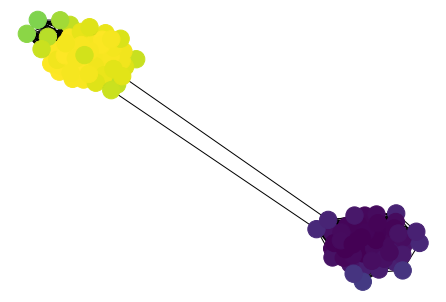

In [14]:
## EDIT THIS CODE

# extract the second eigenvector
second_eigenvector = eigenvecs[:,1] ## <-- SOLUTION

# draw the network structure coloured by the second eigenvector
nx.draw(g, node_color=second_eigenvector)

Lets now binarize our second eigenvector to output a community partition of 0s and 1s.





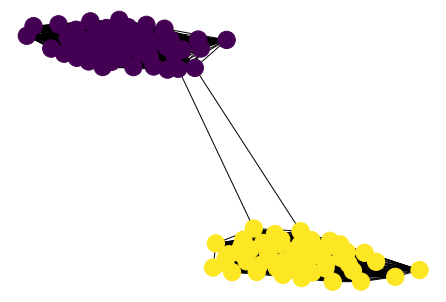

In [15]:
## EDIT THIS CODE

# define a partition and binarize the negative and positive eigenvector values
spectral_partition = second_eigenvector
spectral_partition[spectral_partition<0] = 0 ## <-- SOLUTION
spectral_partition[spectral_partition>0] = 1 ## <-- SOLUTION

# draw the spectral partition
nx.draw(g, node_color=spectral_partition)


## 4. Modularity

The modularity function is defined as,

$
Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m}\right)
            \delta(c_i,c_j)
$

where $m$ is the number of edges, $A$ is the adjacency matrix of `G`, $k_i$ is the degree of $i$ and $\delta(c_i, c_j)$ is 1 if $i$ and $j$ are in the same community and 0 otherwise.

Here, I want you to perform this computation just using a simple nested loop over all pairs of nodes.


In [16]:
## EDIT THIS CODE

# compute the weighted degree vector
degree_weighted = A.sum(axis=1)

# computing the total edge weight of the network
m = degree_weighted.sum() / 2

# looping over each pair of nodes
Q = 0
for i in range(A.shape[0]):
  for j in range(A.shape[0]):

    # only look at nodes within the same community
    if spectral_partition[i]==spectral_partition[j]:
      # add the difference between edge and expected edge weight based on degree
      Q += A[i,j] - ((degree_weighted[i]*degree_weighted[j])/(2*m)) ## <-- SOLUTION

# finally normalise by the total edge weight
Q = (1/(2*m))*Q ## <-- SOLUTION

print('The modularity computed using our manual loop is: {}'.format(Q))

The modularity computed using our manual loop is: 0.49928882726527724


We can confirm that our approach was correct by using the inbuilt modularity function in networkx.

In [17]:
# defining a set for each community
community_0 = set(np.where(spectral_partition==0)[0])
community_1 = set(np.where(spectral_partition==1)[0])
partition = [community_0,community_1]

# using the modularity function in networkx
Q = nx.algorithms.community.modularity(g,partition)
print('The modularity computed using the networkx function is: {}'.format(Q))

The modularity computed using the networkx function is: 0.49928882726527635


## 5. Graph centrality

We now want to identify nodes that are central within our graph. There are various methods for identifying node centrality, which measure different structural properties of the network.

We will use the classic karate club network from this point onwards.

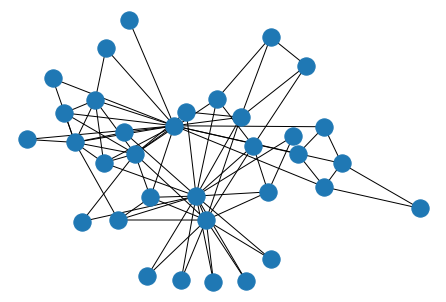

In [18]:
# extracting graph data from networkx
g = nx.karate_club_graph()

# extracting adjacency matrix
A = nx.adjacency_matrix(g).toarray().astype(np.float64)

# drawing graph
nx.draw(g)


Lets first define the degree centrality and then plot it.

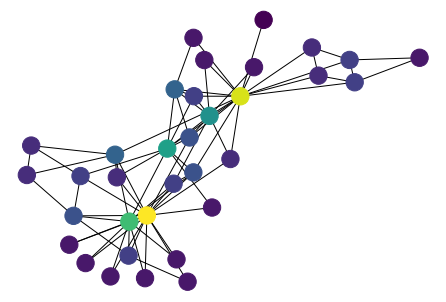

In [19]:
## EDIT THIS CODE

# compute the degree of the adjacency
degree = A.sum(axis=1) ## <-- SOLUTION

# draw the degree distribution
nx.draw(g,node_color=degree)

Lets now plot the eigenvector centrality. Here, we want the eigenvector corresponding to the largest eigenvalue of A.

Lets use the scipy [eigsh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html) function again - but we now want the largest eigenvalue. Hint: look at the 'which' argument in the eigsh function.

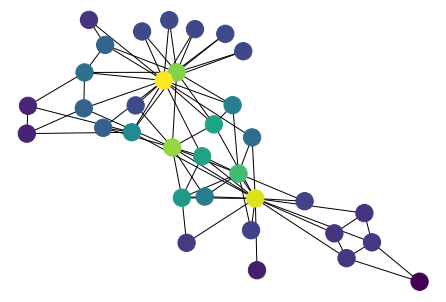

In [20]:
## EDIT THIS CODE

# compute the eigenvector associated with the largest eigenvalue
eigenvalue, eigenvector = linalg.eigsh(A, 1, which="LM", return_eigenvectors=True) ## <-- SOLUTION

# draw the eigenvector centrality
nx.draw(g,node_color=eigenvector)